# Soluções para o espalhamento do cilindro condutor

Neste documento são implementadas as soluções analítica, Ótica Física e Método dos Momentos para o problema do cilindro condutor. Toda implementação é feita em Python.

O primeiro passo é importar as bibliotecas necessárias para as implementações

In [1]:
# Importing standard libraries
import numpy as np
from matplotlib import pyplot as plt

# Importing important constants
from numpy import pi
from numpy import euler_gamma as gamma
from scipy.constants import epsilon_0
from scipy.constants import mu_0

# Importing special functions
from scipy.special import hankel2, jv
from scipy import linalg as lag

Antes de implementarmos as técnicas, é necessário definir alguns parâmetros importantes do problema os quais são: a proporção raio do cilindro por comprimento de onda ($a/\lambda$), a amplitude da onda incidente ($E_0$), a frequência linear de operação do sistema ($f$), a permissividade ($\epsilon$) e a permeabilidade ($\mu$) do espaço livre que envolve o cilindro condutor.

In [2]:
# Main parameters
proportion_radius_to_wavelength = .5
E0 = 1.  # Incident field amplitude [V/m]
f = .3e9  # Linear frequency [Hz]
epsilon = epsilon_0  # Background permittivity [F/m]
mu = mu_0  # Permeability of background [H/m]

A partir da definição desses parâmetros, algumas constantes são definidas: a frequência angular do sistema ($\omega$), o número de onda ($k$), o comprimento de onda ($\lambda$), o raio do cilindro ($a$) e o raio de medição de campo ($\rho$). Esse último será definido como mil vezes o comprimento de onda, ou seja, na região de campo distante.

In [3]:
omega = 2*pi*f  # Angular frequency [rad]
k = omega*np.sqrt(epsilon*mu)  # Wavenumber [1/m]
lambda_b = 2*pi/np.real(k)  # Wavelength [m]
a = proportion_radius_to_wavelength*lambda_b  # Radius of the cylinder [m]
rho = 1000*lambda_b  # Measurement radio [m]

## Solução Analítica

A solução análitica, tanto para o campo espalhado ($E_z^s$) quanto para a corrente induzida na interface do cilindro ($J_z$), é determinada por um somatório infinito. Para a implementação do somatório, é necessário truncar o número de termos. Após sucessivos experimentos, foi definido o seguinte padrão para a escolha do número de termos no somatório:

In [4]:
# Determine the bounds of the sum
if proportion_radius_to_wavelength == .5:
    N = 150
elif proportion_radius_to_wavelength == 5.:
    N = 300
elif proportion_radius_to_wavelength == 50.:
    N = 600
else:
    N = round(8.108*proportion_radius_to_wavelength + 200)

Antes de implementarmos as soluções, é necessário definir também o número de pontos no eixo $\phi$ para o qual o campo e a corrente serão calculados:

In [5]:
# Discretization
NP = 1000  # Number of samples in phi-axis
phi = np.linspace(0, 2*pi, NP)  # Angle coordinates [rad]

O campo espalhado é dado pela seguinte equação: $$ E_z^s = E_0 \sum\limits_{n=-\infty}^{\infty} j^{-n}a_nH_n^{(2)}(k\rho)e^{jn\phi}$$ onde $a_n = \frac{-J_n(ka)}{H_n(2)(ka)}$.

In [6]:
# Scattered field computation
Es_a = np.zeros(NP, dtype=complex)
for n in range(-N, N+1):
    an = -jv(n, k*a)/hankel2(n, k*a)
    Es_a = Es_a + E0*1j**(-n)*an*hankel2(n, k*rho)*np.exp(1j*n*phi)

A corrente é calculada através da seguinte expressão: $$ J_z = -\frac{2E_0}{\omega\mu\pi a} \sum\limits_{n=-\infty}^{\infty} \frac{j^{-n}e^{jn\phi}}{H_n^{(2)}(ka)} $$

In [7]:
# Current computation
Jz_a = np.zeros(NP, dtype=complex)
for n in range(-N, N+1):
    Jz_a = Jz_a + -2*E0/(omega*mu*pi*a)*1j**(-n)*np.exp(1j*n*phi)/hankel2(n, k*a)
phi_a = np.copy(phi)  # Auxiliar variable for plot purposes

## Ótica Física

A solução através da Ótica Física é baseada na aproximação da corrente pelo campo magnético incidente na região da interface do cilindro: 

$$\mathbf{J}_s \approx 2\mathbf{n}\times\mathbf{H}^i, ~\mathrm{em}~ S^\prime$$

Essa solução é definida somente para a região iluminada do cilindro, i.e., $\phi\in[\pi/2, 3\pi/2]$. Por isso, é necessário discretizar o domínio $\phi$ duas vezes: uma para amostrar a corrente na região iluminada onde a integral é definida e outra para calcular o campo na região distante.

In [8]:
# Discretization
NP = 500  # Number of samples in phi-axis
phi = np.linspace(0, 2*pi, NP)  # Angle coordinates (measurement) [rad]
phip = np.linspace(pi/2, 3*pi/2, NP)  # Angle coordinates (integration) [rad]

O campo espalhado total é dado pela seguinte equação:

$$ E_z^s(\rho, \phi) = j E_0ka \sqrt{\frac{1}{2jk\pi\rho}} e^{-jk\rho} \int_{\pi/2}^{3\pi/2} cos\phi^\prime e^{-jka cos\phi^\prime} e^{jka\cos\left(\phi-\phi^\prime \right)} d\phi^\prime $$

In [9]:
# Scattered field computation
Es_p = np.zeros(NP, dtype=complex)
for i in range(NP):
    Es_p[i] = (1j*E0*k*a*np.sqrt(1/(2j*k*pi*rho))*np.exp(-1j*k*rho)
               * np.trapz(np.cos(phip)*np.exp(-1j*k*a*np.cos(phip))
                          * np.exp(1j*k*a*np.cos(phi[i]-phip)), x=phip))

A corrente induzida na interface do cilindro é dada pela seguinte equação:

$$ J_z = -2j\frac{E_0k}{\hat{z}} \cos{\phi} e^{-jka\cos{\phi}} $$

In [10]:
# Current computation
Jz_p = np.zeros(NP, dtype=complex)
for i in range(NP):
    Jz_p[i] = (-2j*E0*k/(1j*omega*mu)*np.cos(phip[i])
               * np.exp(-1j*k*a*np.cos(phip[i])))

# Auxiliar variables for plot purposes
phi_p = np.copy(phi)
phip_p = np.copy(phip)

## Método dos Momentos

No Método dos Momentos são utilizadas as equações integrais de campo elétrico e campo magnético de forma combinada. A equação de campo elétrico é expressa por:

$$ E_0e^{-jka\cos{\phi}} = \frac{\omega\mu}{4} \int_0^{2\pi} J_z(\boldsymbol{\rho}^\prime) H_0^{(2)}(k|\boldsymbol{\rho}-\boldsymbol{\rho}^\prime|) ad\phi^\prime $$

E a equação integral de campo magnético é dada por:

$$ -\frac{E_0}{\eta}\cos{\phi}e^{-jka\cos{\phi}} = \frac{J_z(\boldsymbol{\rho})}{2} + \frac{jk}{4}\int_0^{2\pi} J_z(\boldsymbol{\rho}^\prime) H_1^{(2)}(k|\boldsymbol{\rho}-\boldsymbol{\rho}^\prime|) \cos{\Phi} ad\phi^\prime$$

*OBS*: Essas integrais são integrais de valor principal, onde é excluído o ponto de singularidade. O símbolo para expressar isso nessa linguagem de escrita não foi encontrado.

Para resolver essas equações combinadas, é necessário discretizar o círculo de interface do cilindro em segmentos. Nessa implementação, por questões de simplicadade, o círculo será discretizado em segmentos uniformemente espaçados com coordenada $\rho$ fixa.

In [11]:
# Discretization
NP = 100
DP = 2*pi/NP  # phi discretization
phi = np.arange(DP/2, 2*pi, DP)  # Angle coordinates [rad]
DSn = 2*pi*a/NP  # Size of the segments
eta = np.sqrt(mu/epsilon)  # Intrisic impedance

A partir disso, um sistema linear $V = ZI$ é montado onde o lado esquerdo da equação é determinado por: 

$$ V_m = E_0 e^{-jka\cos{\phi_m}} \left( 1- \frac{1}{\eta}\cos{\phi_m} \right),~ m = 1, \cdots, N $$

In [12]:
# Left-hand side
V = (E0*np.exp(-1j*k*a*np.cos(phi))
     - E0/eta*np.cos(phi)*np.exp(-1j*k*a*np.cos(phi)))

E a matriz de coeficientes $Z$ é determinada por:

$$ Z_{mn} = \begin{cases}  \frac{\omega\mu}{4}H_0^{(2)}(k|\boldsymbol{\rho}_m-\boldsymbol{\rho}_n|)\Delta_{S_n} + \frac{jk}{4}H_1^{(2)}(k|\boldsymbol{\rho}_m-\boldsymbol{\rho}_n|)\cos\Phi_{mn}\Delta_{S_n},~ &m\neq n \\  \frac{\omega\mu\Delta_{S_n}}{4}\left\{1-\frac{j2}{\pi}\left[\ln\left(\frac{k\Delta_{S_n}}{4}\right) + \gamma - 1\right]\right\} + 1/2,~ &m=n \end{cases} $$

In [13]:
# Coefficient matrix
Z = np.zeros((NP, NP), dtype=complex)
for m in range(NP):
    for n in range(NP):
        if m != n:
            R = np.sqrt(a**2 + a**2 - 2*a*a*np.cos(phi[m]-phi[n]))
            Z[m, n] = (omega*mu/4*hankel2(0, k*R)*DSn
                       + 1j*k/4*hankel2(1, k*R)*(a-a*np.cos(phi[m]-phi[n]))/R
                       * DSn)
        else:
            Z[m, n] = (omega*mu*DSn/4*(1 - 2j/pi*(np.log(k*DSn/4)+gamma-1))
                       + 1/2)


O sistema linear é resolvido por uma rotina padrão e a solução é a corrente $J_z$. A partir dessa corrente, o campo elétrico espalhado pode ser aproximado por:

$$ E_z^s(\boldsymbol{\rho}) = \frac{-\omega\mu}{4} \sqrt{\frac{j2}{\pi k\rho}} e^{-jk\rho} \sum\limits_{n=1}^N I_n e^{jka\cos(\phi-\phi_n)}\Delta_{S_n} $$

In [14]:
# Compute current and scattered field
Jz_m = lag.solve(Z, V)
Es_m = np.zeros(phi.size, dtype=complex)
for m in range(NP):
    Es_m[m] = (-omega*mu/4*np.sqrt(2j/(pi*k*rho))*np.exp(-1j*k*rho)
               * np.sum(Jz_m*np.exp(1j*k*a*np.cos(phi[m]-phi))*DSn))

phi_m = np.copy(phi)  # auxiliar variable for plot purposes

## Análise dos resultados

Dados os resultados, podemos plotar os gráficos de corrente e campo através das seguintes linhas de comando:

### Campo Espalhado

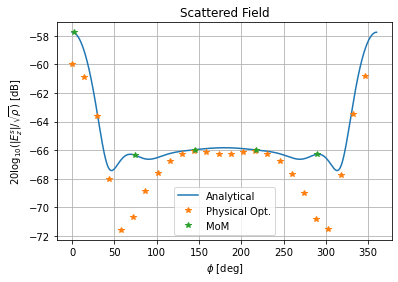

In [15]:
N = 20  # Decreasing the number of points for physical optics and MoM solutions

# Plot Scattered field (E_z^s)
plt.plot(np.rad2deg(phi_a), 20*np.log10(np.abs(Es_a)/np.sqrt(rho)),
         label='Analytical')
plt.plot(np.rad2deg(phi_p[::N]), 20*np.log10(np.abs(Es_p[::N])/np.sqrt(rho)),
         '*', label='Physical Opt.')
plt.plot(np.rad2deg(phi_m[::N]), 20*np.log10(np.abs(Es_m[::N])/np.sqrt(rho)),
         '*', label='MoM')
plt.grid()
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel(r'$20\log_{10}(|E^s_z|/\sqrt{\rho})$ [dB]')
plt.title('Scattered Field')
plt.legend()
plt.show()

### Corrente induzida

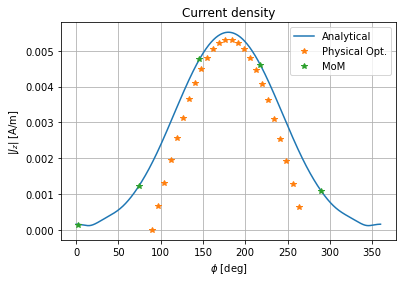

In [16]:
# Plot Induced Current (J_z)
plt.plot(np.rad2deg(phi_a), np.abs(Jz_a), label='Analytical')
plt.plot(np.rad2deg(phip_p[::N]), np.abs(Jz_p[::N]), '*',
         label='Physical Opt.')
plt.plot(np.rad2deg(phi_m[::N]), np.abs(Jz_m[::N]), '*',
         label='MoM')
plt.grid()
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel(r'$|J_z|$ [A/m]')
plt.title('Current density')
plt.legend()
plt.show()